<a href="https://colab.research.google.com/github/maneshnambiar/ai-pneumonia-detection/blob/master/RNSA_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [44]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"paulsubhankar07","key":"9e097c3ddd3a8d6570b08f29275a3772"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [47]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/106k [00:00<?, ?B/s]
100% 106k/106k [00:00<00:00, 40.9MB/s]
  0% 0.00/113k [00:00<?, ?B/s]
100% 113k/113k [00:00<00:00, 37.1MB/s]
  0% 0.00/146k [00:00<?, ?B/s]
100% 146k/146k [00:00<00:00, 48.0MB/s]
  0% 0.00/92.5k [00:00<?, ?B/s]
100% 92.5k/92.5k [00:00<00:00, 29.8MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 51.3MB/s]
  0% 0.00/151k [00:00<?, ?B/s]
100% 151k/151k [00:00<00:00, 47.6MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 47.5MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 52.7MB/s]
  0% 0.00/116k [00:00<?, ?B/s]
100% 116k/116k [00:00<00:00, 38.2MB/s]
  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 112MB/s]
  0% 0.00/149k [00:00<?, ?B/s]
100% 149k/149k [00:00<00:00, 48.3MB/s]
  0% 0.00/133k [00:00<?, ?B/s]
100% 133k/133k [00:00<00:00, 42.9MB/s]
  0% 0.00/119k [00:00<?, ?B/s]
100% 119k/119k [00:00<00:00, 34.6MB/s]
  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 116MB/s]
  0% 0.00/115k [00:

In [0]:
#IMport Libraries

import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [0]:
import pydicom

In [49]:
!pip install pydicom

In [0]:
import pydicom

In [0]:
DATA_DIR = '/content'

# Directory to save logs and trained model
ROOT_DIR = '/content'

In [76]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

#!git clone https://github.com/tomgross/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.82 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (568/568), done.


In [77]:
os.chdir('Mask_RCNN')

FileNotFoundError: ignored

In [0]:
!rm -rf 'Mask_RCNN'

In [0]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log



In [0]:
train_dicom_dir = os.path.join(DATA_DIR, '/drive/My Drive/stage_2_train_images/IMG/IMG')
test_dicom_dir = os.path.join(DATA_DIR, '/drive/My Drive/stage_2_test_images/stage_2_test_images')

In [54]:
#Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [73]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Some setup functions and classes for Mask-RCNN
dicom_fps is a list of the dicom image path and filenames
image_annotions is a dictionary of the annotations keyed by the filenames
parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [0]:
dicom_Dt=glob.glob(train_dicom_dir+'/'+'*.dcm')

In [78]:
dicom_Dt

[]

In [56]:
patientId = anns['patientId'][0]
dcm_file = '/content/drive/My Drive/stage_2_train_images/IMG/IMG/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [64]:
dicom_Dt

[]

In [0]:
 image_annotations = {fp: [] for fp in image_fps}

In [57]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
#Examine the annotation data, parse the dataset, and view dicom fields

import pandas as pd
anns = pd.read_csv('/content/stage_2_train_labels.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

In [60]:
# training dataset
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
!pwd

/content


In [0]:
#Read the Image File
#Upload FOlders to Drive 
#Import it from DRIVE


In [0]:
!unzip -uq "/content/drive/My Drive/stage_2_test_images.zip" -d "/content/drive/My Drive/stage_2_test_images"


In [0]:
!unzip -uq "/content/drive/My Drive/stage_2_train_images.zip" -d "/content/drive/My Drive/stage_2_train_images"


unzip:  cannot find or open /content/drive/My Drive/stage_2_train_images.zip, /content/drive/My Drive/stage_2_train_images.zip.zip or /content/drive/My Drive/stage_2_train_images.zip.ZIP.


In [0]:
image_fps, image_annotations = parse_dataset('/content/drive/My Drive/stage_2_train_images/IMG/IMG/', anns=anns)

In [23]:
anns.head(50)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [62]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23088.1517874445.429262
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '68af451d-8222-43c4-8753-2b70cbbfb194'
(0010, 0020) Patient ID                          LO: '68af451d-8222-43c4-8753-2b70cbbfb194'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [64]:
#Split the data into training and validation datasets


image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


In [0]:
#Create and prepare the training dataset using the DetectorDataset class.
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [66]:
#Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    15cfe136-58ea-4e38-b3a8-d372ecad4ac7
 x                                             396
 y                                             262
 width                                         206
 height                                        249
 Target                                          1
 Name: 1402, dtype: object, patientId    15cfe136-58ea-4e38-b3a8-d372ecad4ac7
 x                                             738
 y                                             357
 width                                         234
 height                                        315
 Target                                          1
 Name: 1403, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()


In [0]:
#Display a random image with bounding boxes¶


(1024, 1024, 3)
/content/drive/My Drive/stage_2_train_images/IMG/IMG/36f775ee-d044-43a3-bbe5-000ed7b498b8.dcm
[1]


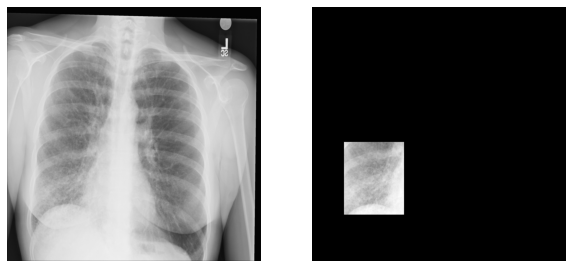

In [68]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)


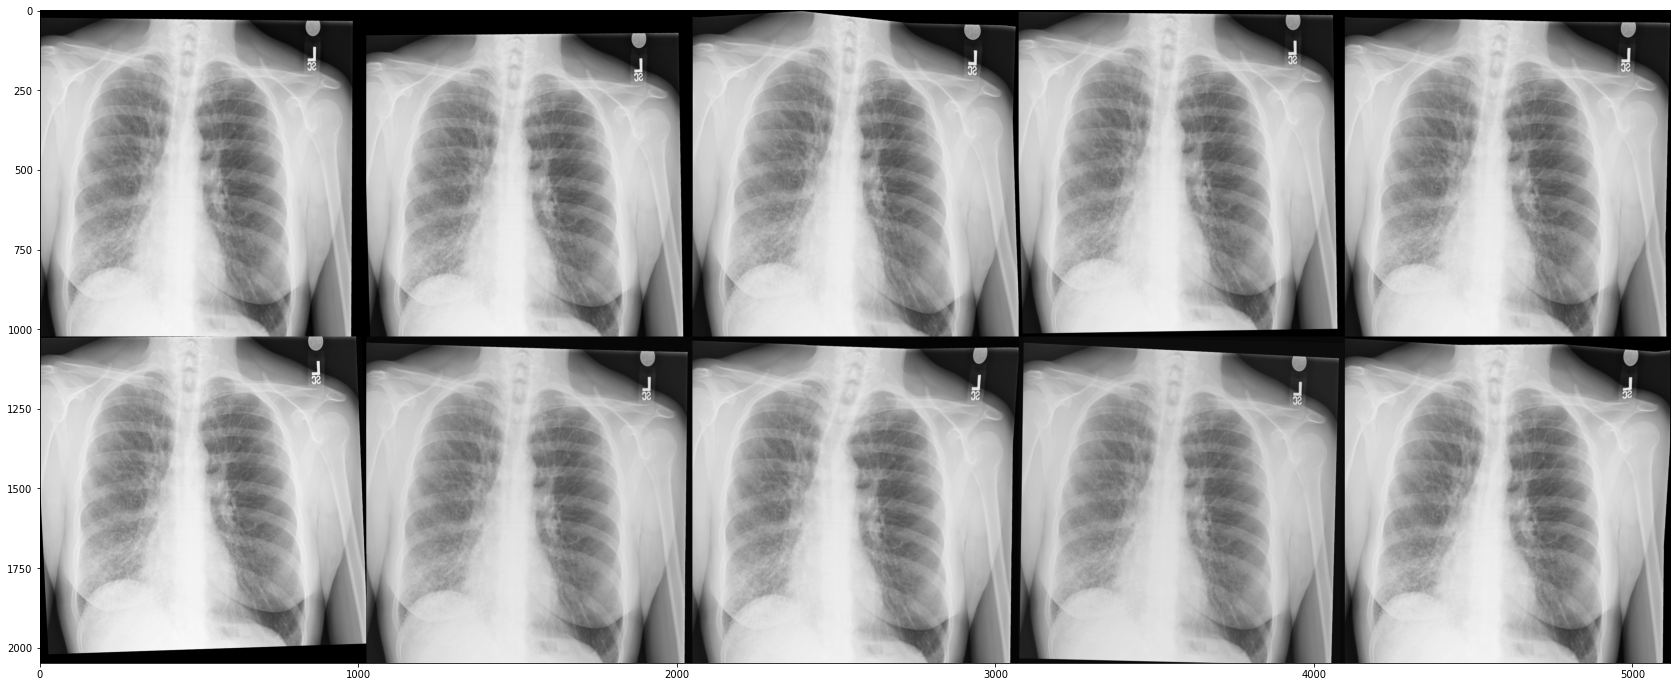

In [69]:
#Image Augmentation. Try finetuning some variables to custom values¶
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
plt.imshow(imggrid[:, :, 0], cmap='gray')


#Now it's time to train the model. Note that training even a basic model can take a few hours.


dataset_train and dataset_val are derived from DetectorDataset
DetectorDataset loads images from image filenames and masks from the annotation data
model is Mask-RCNN

In [70]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

AttributeError: ignored

In [0]:
import tensorflow as tf

In [74]:
print(tf.__version__)

2.2.0-rc3
